In [20]:
import os
import re
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [153]:
batch_size = 16

In [164]:
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.2, 
                             zoom_range = 0.04)

img = load_img('data/train/cat/204.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [155]:
datagen_aug = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2, 
                                 horizontal_flip=True,
                                 zoom_range = 0.04)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator  = datagen_aug.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='training')

validation_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [156]:
model = Sequential()
model.add(Conv2D(32, (3, 3), batch_size=batch_size, input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [157]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              validation_data=validation_generator,
                              steps_per_epoch=40000 // batch_size,
                              validation_steps=10000 // batch_size)

Epoch 1/2
5000/5000 [==============================] - 38s 8ms/step - loss: 1.7610 - accuracy: 0.3459 - val_loss: 1.7377 - val_accuracy: 0.4960
Epoch 2/2
5000/5000 [==============================] - 37s 7ms/step - loss: 1.4988 - accuracy: 0.4570 - val_loss: 1.2662 - val_accuracy: 0.5404


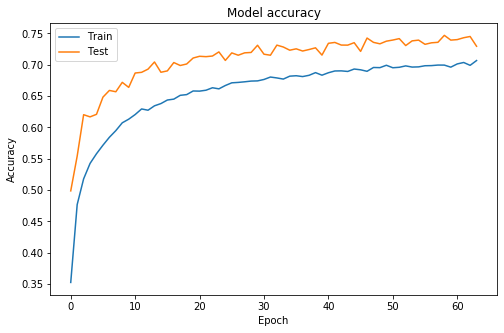

In [125]:
f = plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#f.savefig('shift3_0-64.svg', bbox_inches='tight')

In [128]:
model.save_weights('73(+75)_1880s_batch16(aug_hflip,shift3)_epoch64+1_cnv32_cnv64_dns64_drop0.5_dns10_adam.h5')

In [80]:
model.load_weights('69_480s_batch16_epoch10_cnv32_cnv64_dns64_drop0.5_dns10_adam.h5')

In [83]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test',
                                                   target_size=(32, 32),
                                                   batch_size=batch_size,
                                                   shuffle=False)

Found 300000 images belonging to 1 classes.


In [84]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

18750/18750 [==============================] - 266s 14ms/step


In [85]:
indices = np.argmax(pred, axis=1)

In [88]:
ids = [int(re.sub('\D+', '', name)) for name in test_generator.filenames]

In [89]:
flipped = {v:k for k,v in validation_generator.class_indices.items()}

In [90]:
labels = [flipped[i] for i in indices]

In [91]:
submission = pd.DataFrame({'id':ids, 'label':labels}).sort_values(['id']).reset_index(drop=True)

In [92]:
submission.to_csv('submission.csv', index=False)

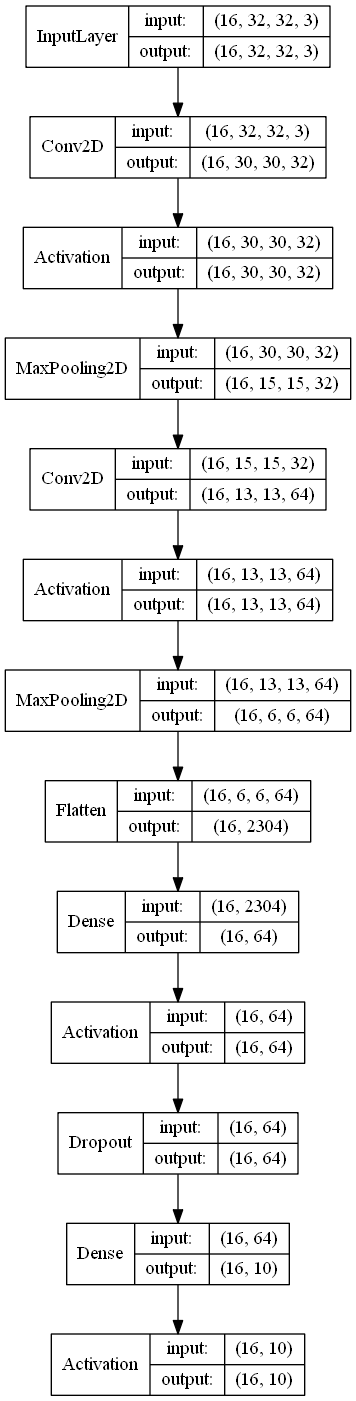

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=False, show_shapes=True)